# Imports

In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits, ascii
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
import time
import copy
import sbi
from sbi import utils as utils
from sbi.inference import infer, SNPE
import torch
from joblib import dump, load
from tqdm import tqdm

from minot.ClusterTools import map_tools
import pitszi

# Parameters

In [2]:
output_dir = '/Users/radam/Desktop/PITSZItestSBI/'

In [3]:
#----- Physical model parameters
# Global
redshift = 0.5
M500 = 1e15*u.Msun
RA, Dec   = 30*u.deg, 55*u.deg
dRA, dDec = 30*u.arcsec, -10*u.arcsec
axis_q1, axis_q2 = 0.7, 0.7
euler_1, euler_2, euler_3 = 0*u.deg, 90*u.deg, 35*u.deg

# Fluctuations
fluct_norm = 0.5
fluct_slope = -11./3
fluct_linj = 500*u.kpc
fluct_statistics = 'gaussian'
fluct_seed = 1

In [4]:
#----- Instrumental parameters
# Beam smoothing
beam_FWHM = 10*u.arcsec

# Transfer function
karcsec = np.linspace(0, 1/beam_FWHM.to_value('arcsec')*10, 1000)*u.arcsec**-1
kfov = 1/(7*60)
TF = {'k':karcsec, 'TF':1-np.exp(-karcsec.to_value('arcsec-1')/kfov)}

# Mask
mask_Ntheta500 = 0.75

# Noise
noise_k = lambda k_arcsec: (2e-10 + 2e-10 * (k_arcsec*60)**-1)
noise_r = lambda r_arcsec: (1 + np.exp((r_arcsec-200)/80))
noise_seed = None
noise_Nsim = 1000

# CIB
CIB_reproc = False
CIB_Nsim = 1000
cib_seed = 0
include_CIB = False

In [5]:
#----- Analysis parameters
# Pk measurement
Nbins_pk = 10
scale_bins = 'log'
kmin_pk = 1/(60*2)*u.arcsec**-1
kmax_pk = 1/(2*beam_FWHM.to('arcsec'))

# weight definition
method_w8_radial  = True
method_w8_smooth  = 20*u.arcsec
method_w8_beam    = True
method_w8_TF      = False

# methodology
method_data_deconv = False
method_use_covmat  = True
method_parallel    = False

method_setup_overwrite = False

# Data simulation

### Mock definition

In [6]:
#===== Generate a model for the cluster and its fluctuations
mock = pitszi.Model(RA=RA+dRA, Dec=Dec+dDec, redshift=redshift, M500=M500, silent=True, output_dir=output_dir)
mock.model_seed_fluctuation = fluct_seed
mock.set_pressure_profile_universal_param('A10MD')
mock.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                   'statistics':fluct_statistics,
                                   'Norm': fluct_norm, 
                                   'slope': fluct_slope,
                                   'Linj': fluct_linj,
                                   'Ldis': 1*u.kpc}
mock.triaxiality = {'min_to_maj_axis_ratio':axis_q1, 'int_to_maj_axis_ratio':axis_q2,
                    'euler_angle1':euler_1, 'euler_angle2':euler_2, 'euler_angle3':euler_3}
if fluct_seed is not None: mock.model_seed_fluctuation = fluct_seed

mock.map_center = SkyCoord(RA, Dec, frame="icrs")
mock.map_fov    = [5, 4]*u.arcmin
mock.map_reso  = 5*u.arcsec
mock.los_reso  = 50*u.kpc
mock.los_size  = 2*u.Mpc
mock.R_truncation = mock.R500*10

mock.give_sampling_information()

===== Information relative to the grid sampling =====
   Grid size : 59 , 49 , 41
   Pixel size :      31.4     kpc ;     5.0      arcsec
   Fov size :  [   1855.0   ,   1540.6   ] kpc ; [   4.917    ,   4.083    ] arcmin
   L.o.S. resolution :         50.0     kpc
   Map center :   <SkyCoord (ICRS): (ra, dec) in deg
    (30., 55.)>
   k min/max projected :       0.003390  /  0.098305   1/arcsec
   k min/max projected :       0.000539  /  0.015633   1/kpc
   k min/max L.o.S. (eq.) :    0.003067  /  0.061349   1/arcsec
   k min/max L.o.S. :          0.000488  /  0.009756   1/kpc
   k max Nyquist :             0.061349   1/arcsec
   k max Nyquist :             0.009756   1/kpc


### CIB Monte Carlo 

In [7]:
def simu_cib(header, beam_FWHM, TF, Nsim=1000, Scut_high=100, Scut_low=0.0):
    y2mjy = -12e3
    sigma2fwhm = 2*np.sqrt(2*np.log(2))

    RA0, Dec0 = header['CRVAL1'], header['CRVAL2']
    ramap, decmap = map_tools.get_radec_map(header)
    src = np.zeros((Nsim, header['NAXIS2'], header['NAXIS1']))
    
    path     = '/Users/radam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/sides-public-release-main/cats/CIB_cat_sim/'
    ignored  = {".DS_Store"}
    catfiles = [x for x in os.listdir(path) if x not in ignored]
    np.random.shuffle(catfiles)
    
    for imc in range(Nsim):
        if Nsim>1 and imc % 10 == 0: print(imc, '/', Nsim)
        hdul = fits.open(path+catfiles[imc])
        cat_imc = hdul[1].data
        hdul.close()
        w1 = cat_imc['SNIKA2000']*1e3 > Scut_low
        w2 = cat_imc['SNIKA2000']*1e3 < Scut_high
        cat_imc = cat_imc[w1*w2]
        
        src_imc = np.zeros((header['NAXIS2'], header['NAXIS1']))
        for isrc in range(len(cat_imc)):
            dist_map = map_tools.greatcircle(ramap, decmap, RA0+cat_imc['ra'][isrc], Dec0+cat_imc['dec'][isrc])
            flux = cat_imc['SNIKA2000'][isrc]*1e3
            src_imc += flux*np.exp(-dist_map**2/2/(beam_FWHM.to_value('deg')/sigma2fwhm)**2)
                
        img_conv = pitszi.utils_pk.apply_transfer_function(src_imc, header['CDELT2']*3600, beam_FWHM.to_value('arcsec'), TF)
        src[imc,:,:] = img_conv
                
    return src/y2mjy

In [8]:
CIB_exist = os.path.exists(output_dir+'/CIB_MC.joblib')
if CIB_reproc or not CIB_exist:
    cib_mc = simu_cib(mock.get_map_header(), beam_FWHM, TF, Nsim=CIB_Nsim, Scut_high=0.1, Scut_low=0.001)
    dump(cib_mc, output_dir+'/CIB_MC.joblib')
else:
    cib_mc = load(output_dir+'/CIB_MC.joblib')

### Data

In [9]:
#===== Initiate a data object and fake data
#----- Init with the mock
data = pitszi.Data(mock.get_sz_map(), mock.get_map_header())
data.output_dir = output_dir

#----- set basic IRFs
data.psf_fwhm              = beam_FWHM
data.transfer_function     = TF
data.noise_model = [noise_r, noise_k]

#----- Define the mask
ramap, decmap = map_tools.get_radec_map(data.header)
dist_map = map_tools.greatcircle(ramap, decmap, (RA+dRA).to_value('deg'), (Dec+dDec).to_value('deg'))
mask = dist_map * 0 + 1
mask[dist_map > mask_Ntheta500*mock.theta500.to_value('deg')] = 0 
data.mask = mask

#----- Define the noise properties
data.noise_mc = data.get_noise_monte_carlo_from_model(Nmc=noise_Nsim, center=mock.get_map_center())
data.noise_rms = data.get_noise_rms_from_model(Nmc=noise_Nsim, center=mock.map_center)
if os.path.exists(data.output_dir+'/data_image_noise_covariance_matrix.pkl'):
    data.load_noise_covariance(data.output_dir+'/data_image_noise_covariance_matrix.pkl')
else:
    data.noise_covmat = data.get_noise_covariance_from_model(Nmc=noise_Nsim)
    data.save_noise_covariance(data.output_dir+'/data_image_noise_covariance_matrix.pkl')

#----- Mock the data
img = data.set_image_to_mock(mock, model_no_fluctuations=False, 
                             noise_origin='model', noise_center=mock.get_map_center(), noise_seed=noise_seed)
if include_CIB:
    data.image += cib_mc[cib_seed]

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                           Data                             
------------------------------------------------------------


/var/folders/vn/s8_3jv496gz7jpw5mh082r8r0000gn/T/ipykernel_36872/3491779490.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  noise_k = lambda k_arcsec: (2e-9 + 2e-9 * (k_arcsec*60)**-1)*1e-1
/var/folders/vn/s8_3jv496gz7jpw5mh082r8r0000gn/T/ipykernel_36872/3491779490.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  noise_k = lambda k_arcsec: (2e-9 + 2e-9 * (k_arcsec*60)**-1)*1e-1
/var/folders/vn/s8_3jv496gz7jpw5mh082r8r0000gn/T/ipykernel_36872/3491779490.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  noise_k = lambda k_arcsec: (2e-9 + 2e-9 * (k_arcsec*60)**-1)*1e-1


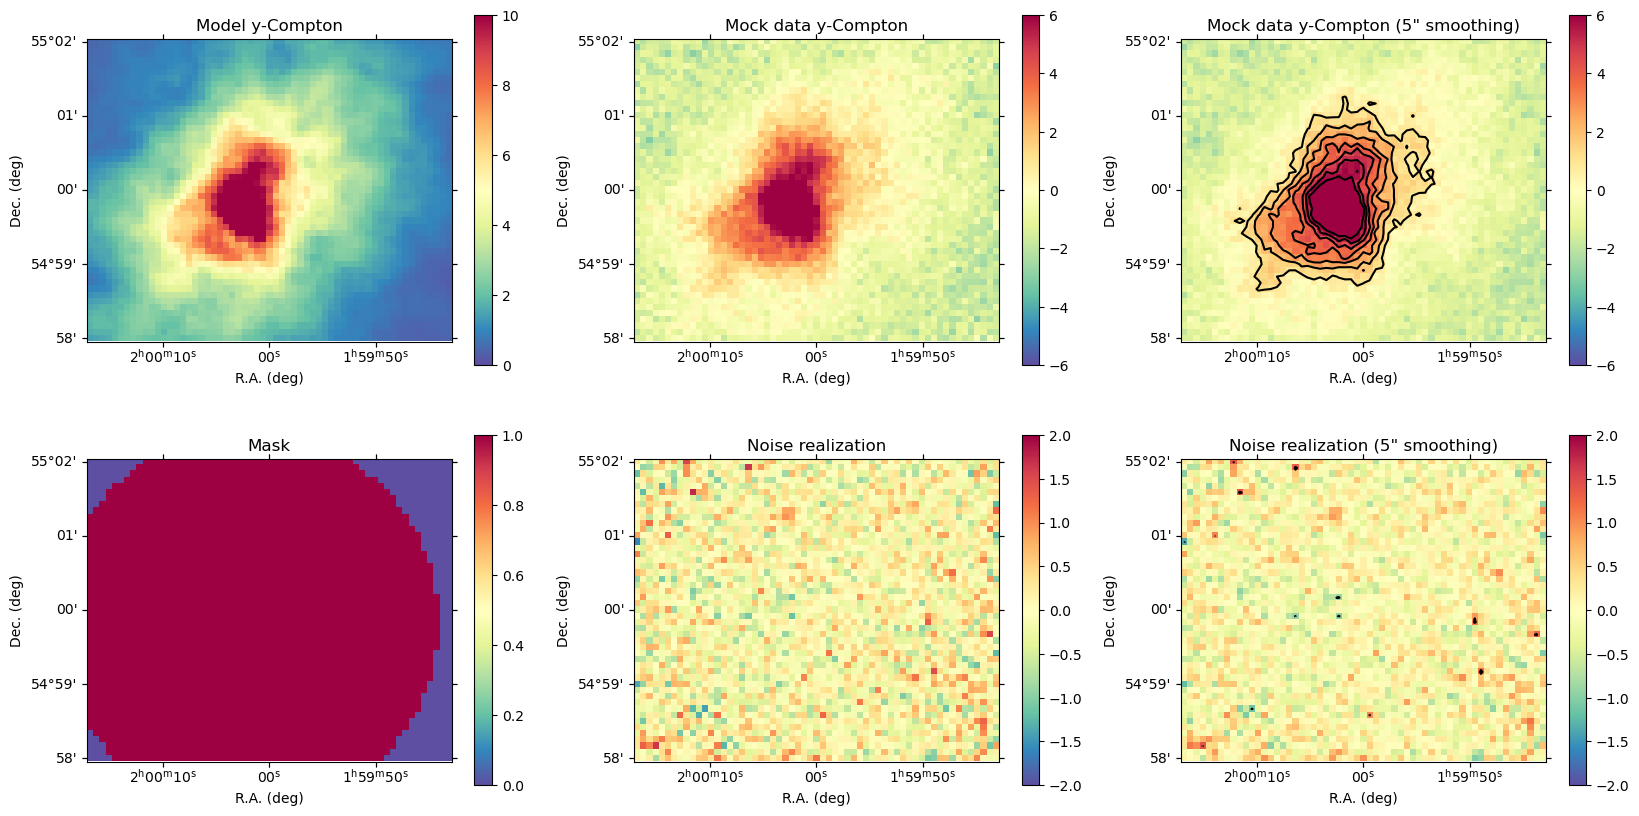

In [10]:
visu_smooth = 5

#===== Show the data
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(20, 10))

ax = plt.subplot(2, 3, 1, projection=WCS(data.header))
plt.imshow(mock.get_sz_map(no_fluctuations=False)*1e5, cmap='Spectral_r', vmin=0, vmax=10)
cb = plt.colorbar()
plt.title('Model y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 2, projection=WCS(data.header))
plt.imshow(data.image*1e5, cmap='Spectral_r',vmin=-6, vmax=6)
cb = plt.colorbar()
plt.title('Mock data y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 3, projection=WCS(data.header))
plt.imshow(gaussian_filter(data.image, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5, cmap='Spectral_r', vmin=-6, vmax=6)
cb = plt.colorbar()
rms = np.std(gaussian_filter(data.noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(data.image, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)/rms, levels=[3,6,9,12,15,18,21], colors='k')
plt.title('Mock data y-Compton ('+str(int(visu_smooth))+'" smoothing)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 4, projection=WCS(data.header))
plt.imshow(data.mask, cmap='Spectral_r', vmin=0, vmax=1)
cb = plt.colorbar()
plt.title('Mask')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 5, projection=WCS(data.header))
plt.imshow(data.noise_mc[0]*1e5, cmap='Spectral_r', vmin=-2, vmax=2)
cb = plt.colorbar()
plt.title('Noise realization')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 6, projection=WCS(data.header))
plt.imshow(gaussian_filter(data.noise_mc[0], sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5, cmap='Spectral_r', vmin=-2, vmax=2)
cb = plt.colorbar()
rms = np.std(gaussian_filter(data.noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(data.noise_mc[0], sigma=visu_smooth/2.35/data.header['CDELT2']/3600)/rms, levels=[-3,3], colors='k')
plt.title('Noise realization ('+str(int(visu_smooth))+'" smoothing)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

# Define the inference

In [11]:
model = copy.deepcopy(mock)

In [12]:
cl_Finfer = pitszi.InferenceFluctuation(data, model,
                                        method_use_covmat=method_use_covmat, 
                                        silent=False,
                                        output_dir=output_dir)

if include_CIB: cl_Finfer.nuisance_bkg_mc1 = cib_mc

#----- Define binning
cl_Finfer.kbin_min   = kmin_pk
cl_Finfer.kbin_max   = kmax_pk
cl_Finfer.kbin_Nbin  = Nbins_pk
cl_Finfer.kbin_scale = scale_bins

#----- Weight definition
RA0, Dec0 = data.header['CRVAL1'], data.header['CRVAL2']
ramap, decmap = map_tools.get_radec_map(data.header)
dist_map = map_tools.greatcircle(ramap, decmap, RA0, Dec0)*60
roi = dist_map*0
roi[dist_map < 3] = 1
cl_Finfer.set_method_w8(roi_mask=roi,
                        apply_radial_model=method_w8_radial, 
                        conv_radial_model_beam=method_w8_beam, 
                        conv_radial_model_TF=method_w8_TF, 
                        remove_GNFW_core=True,
                        smooth_FWHM=method_w8_smooth)
    
#----- Setup
cl_Finfer.pk_setup(Nmc=1000)

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                 Fluctuation Inference                      
------------------------------------------------------------
----- Checking the inputs -----
      - Data1, data2, and model projection OK.
----- Running the setup -----
The setup is necessary for inference on the power spectrum:
- Compute map resolution and k binning information         
- compute ymap residual to be used for Pk extraction       
- compute the smooth model                                 
- extract Pk data, reference model and noise properties    
- compute conversion from Pk 2d to Pk3d   

# CIB data augmentation devs

In [13]:
k2d, pk2d_data = cl_Finfer.get_pk2d_data(physical=True)

In [14]:
cl_Finfer._pk2d_noise_mc

array([[ 21.08540676,  44.1553682 ,  62.25924768, ...,  35.10069853,
         40.11759522,  34.68078672],
       [100.0223602 ,  67.08168226,  49.83668404, ...,  32.73715689,
         25.42262609,  24.76058138],
       [118.75572562,  42.10750401,  65.22253154, ...,  37.42698215,
         34.34333631,  20.0704705 ],
       ...,
       [  5.20312846,  66.5226975 ,   2.8941426 , ...,  40.93855472,
         32.22436006,  34.36137155],
       [111.39007638,  14.94529533,  13.79960005, ...,  26.51438322,
         33.71430556,  28.10094269],
       [ 25.61607229,  51.93797491,  20.44743475, ...,  33.98765378,
         31.09802077,  33.97674511]])

In [15]:
dlnc = pitszi.utils_pk.pk_data_augmentation(k2d, cl_Finfer._pk2d_noise_mc, Nsim=100, method='LogNormCov')
dnni = pitszi.utils_pk.pk_data_augmentation(k2d, cl_Finfer._pk2d_noise_mc, Nsim=100, method='NearNeighborsItpl', n_nearest=99)

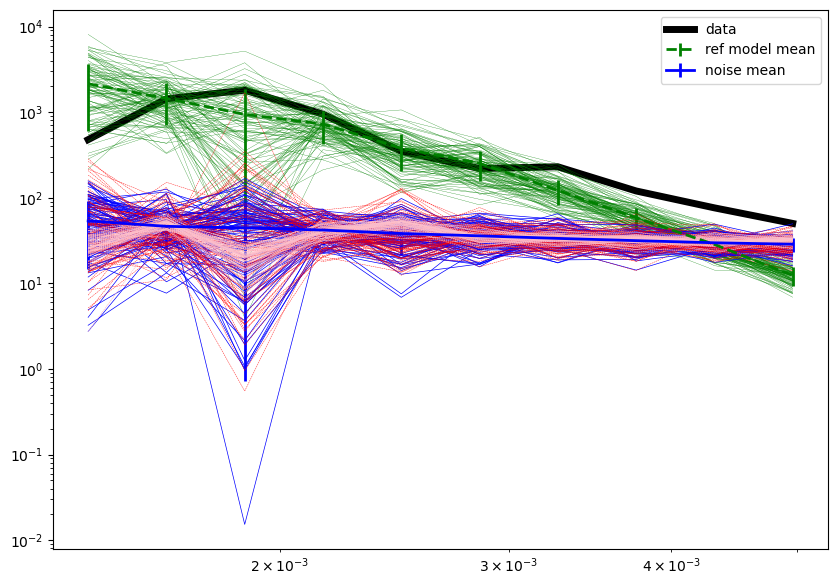

In [16]:
plt.figure(figsize=(10,7))
plt.loglog(k2d, pk2d_data, color='k', lw=5, label='data')
plt.errorbar(cl_Finfer._kctr_kpc, cl_Finfer._pk2d_modref, cl_Finfer._pk2d_modref_rms, color='green', ls='--', lw=2, label='ref model mean')
for i in range(100): plt.loglog(cl_Finfer._kctr_kpc, cl_Finfer._pk2d_modref_mc[i], color='green', lw=0.2)
plt.errorbar(cl_Finfer._kctr_kpc, cl_Finfer._pk2d_noise, cl_Finfer._pk2d_noise_rms, color='blue', ls='-', lw=2, label='noise mean')
for i in range(100): plt.loglog(cl_Finfer._kctr_kpc, cl_Finfer._pk2d_noise_mc[i], color='blue', lw=0.5)
for i in range(100): plt.loglog(k2d, dlnc[i], color='red', lw=0.3, ls='--')
for i in range(100): plt.loglog(k2d, dnni[i], color='pink', lw=0.3, ls='--')
plt.xscale('log')
plt.yscale('log')
plt.legend()

# SBI

### Curvefit and MCMC for reference 

In [17]:
parinfo = {
    'Norm':{'guess':[0.5, 0.5],'unit': None,'limit':[0, 2]},
    'Linj':{'guess':[800, 400],'unit': u.kpc,'limit':[50, 3000]},
    #'Anoise':{'guess':[1, 0.1],'unit': None,'limit':[0, 2]},
    #'Abkg':{'guess':[1, 0.2],'unit': None,'limit':[0.0, 3], 'prior':[1, 1]},
}

cf_res = cl_Finfer.run_curvefit_fluctuation(parinfo, include_model_error=True,
                                            show_fit_result=True, true_param=[0.5,800])

----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Parameter best-fit: -----
     param 0 (Norm) = 0.5953026407357355 +/- 0.04030528432856005
     param 1 (Linj) = 504.3495732503973 +/- 118.20982816245561
   --- Parameter sampling: chain statistics ---
param 0 (Norm): 
   median   = 0.5949611946986733 -0.03924500327626623 +0.040180308245062135
   best-fit = 0.5953026407357355 -0.03958644931332844 +0.039838862207999926
   Norm = 0.5949611946986733_{-0.03924500327626623}^{0.040180308245062135}
param 1 (Linj): 
   median   = 505.8017821751607 -120.61185901940507 +118.23314350510827
   best-fit = 504.3495732503973 -119.15965009464168 +119.68535242987167
   Linj = 505.8017821751607_{-120.61185901940507}^{118.23314350510827}


In [18]:
parinfo = {
    'Norm':{'guess':[0.5, 0.5],'unit': None,'limit':[0, 2]},
    'Linj':{'guess':[800, 400],'unit': u.kpc,'limit':[50, 3000]},
    #'Anoise':{'guess':[1, 0.1],'unit': None,'limit':[0, 2]},
    #'Abkg':{'guess':[1, 0.2],'unit': None,'limit':[0.0, 3], 'prior':[1, 1]},
}

cl_Finfer.mcmc_burnin = 0
cl_Finfer.mcmc_Nresamp = 1000
cl_Finfer.mcmc_nsteps = 2000
cl_Finfer.mcmc_nwalkers = 20
cl_Finfer.mcmc_reset = True
cl_Finfer.mcmc_run = True

mcmc_res = cl_Finfer.run_mcmc_fluctuation(parinfo, include_model_error=True,
                                          show_fit_result=True, true_param=[0.5,800])

----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_MCMC_Fluctuation_sampler.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Starting point mean:          
[5.e-01 8.e+02]
      - Starting point dispersion :   
[  0.5 400. ]
      - Minimal starting point:       
[ 0 50]
      - Maximal starting point:       
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
      - Use covariance matrix?        
True
-----
----- Does the sampler already exist? -----
      - Yes, use the existing MCMC sampler
      - Initial size: 500
----- MCMC sampling -----
      - Not running, but restoring the existing sampler
   --- Parameter sampling: chain statistics ---
param 0 (Norm): 
   median   = 0.5668151341889482 -0.04900280346043162

### SBI fit

In [44]:
parinfo = {
    'Norm':{'guess':[0.5, 0.5],'unit': None,'limit':[0, 2]},
    'Linj':{'guess':[800, 400],'unit': u.kpc,'limit':[50, 3000]},
    #'Anoise':{'guess':[1, 0.1],'unit': None,'limit':[0, 2]},
    #'Abkg':{'guess':[1, 0.2],'unit': None,'limit':[0.0, 3], 'prior':[1, 1]},
}
cl_Finfer.sbi_nsteps = 10000
cl_Finfer.sbi_reset = True
cl_Finfer.sbi_run = True
cl_Finfer.sbi_Nresamp = 1000
sbi_res = cl_Finfer.sbi_fluctuation_training(parinfo)

----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 40 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 45 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50it/s]


      --- Training the network...
 Training neural network. Epochs trained: 62

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 76 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 24 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 34 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 23 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.17it/s]


      --- Training the network...
 Neural network successfully converged after 55 epochs.

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 28 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.01it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 28 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.24it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 26 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.91it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 22 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.66it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 24 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.00it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 41 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.97it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 22 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.91it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 25 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.01it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 28 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.96it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 25 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.06it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 21 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 21 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.00it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 31 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.97it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 27 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.95it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 26 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.99it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 24 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.90it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 24 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 33 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 25 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.96it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 26 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.93it/s]


      --- Training the network...
 Training neural network. Epochs trained: 44

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 56 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.89it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 25 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 23 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.97it/s]


      --- Training the network...
 Training neural network. Epochs trained: 45

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 49 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.98it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 27 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.89it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 27 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.84it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 31 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.17it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 28 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.00it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 24 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.16it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 24 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.84it/s]


      --- Training the network...
 Training neural network. Epochs trained: 43

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 49 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.90it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 27 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 25 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.97it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 24 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.98it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 22 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.85it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 21 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18it/s]


      --- Training the network...
 Training neural network. Epochs trained: 17

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 22 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.96it/s]


      --- Training the network...
 Training neural network. Epochs trained: 24

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 29 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.83it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 23 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.16it/s]


      --- Training the network...
 Training neural network. Epochs trained: 24

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 33 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.86it/s]


      --- Training the network...
 Training neural network. Epochs trained: 24

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 29 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10it/s]


      --- Training the network...
 Training neural network. Epochs trained: 22

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 25 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07it/s]


      --- Training the network...
 Training neural network. Epochs trained: 24

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 25 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.91it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 23 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 21 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.89it/s]


      --- Training the network...
 Neural network successfully converged after 24 epochs.

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21it/s]


      --- Training the network...
 Training neural network. Epochs trained: 23

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 24 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.09it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 23 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.97it/s]


      --- Training the network...
 Neural network successfully converged after 24 epochs.

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10it/s]


      --- Training the network...
 Training neural network. Epochs trained: 23

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 39 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.04it/s]


      --- Training the network...
 Training neural network. Epochs trained: 24

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 30 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.96it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 22 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27it/s]


      --- Training the network...
 Training neural network. Epochs trained: 23

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 26 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.92it/s]


      --- Training the network...
 Training neural network. Epochs trained: 23

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 33 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.13it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 22 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.99it/s]


      --- Training the network...
 Training neural network. Epochs trained: 23

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 31 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.84it/s]


      --- Training the network...
 Training neural network. Epochs trained: 22

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 28 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14it/s]
/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Training the network...
 Neural network successfully converged after 22 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.85it/s]


      --- Training the network...
 Training neural network. Epochs trained: 17

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 23 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.91it/s]


      --- Training the network...
 Training neural network. Epochs trained: 17

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 24 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.24it/s]


      --- Training the network...
 Training neural network. Epochs trained: 17

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 30 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.97it/s]


      --- Training the network...
 Training neural network. Epochs trained: 17

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 23 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.93it/s]


      --- Training the network...
 Training neural network. Epochs trained: 17

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 21 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05it/s]


      --- Training the network...
 Training neural network. Epochs trained: 17

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 25 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.83it/s]


      --- Training the network...
 Training neural network. Epochs trained: 17

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 21 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.94it/s]


      --- Training the network...
 Training neural network. Epochs trained: 15

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 29 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35it/s]


      --- Training the network...
 Training neural network. Epochs trained: 17

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 26 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.92it/s]


      --- Training the network...
 Training neural network. Epochs trained: 16

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 23 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.13it/s]


      --- Training the network...
 Training neural network. Epochs trained: 15

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 26 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.17it/s]


      --- Training the network...
 Training neural network. Epochs trained: 17

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 27 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.78it/s]


      --- Training the network...
 Training neural network. Epochs trained: 16

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 23 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.95it/s]


      --- Training the network...
 Training neural network. Epochs trained: 15

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 23 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.16it/s]


      --- Training the network...
 Training neural network. Epochs trained: 34

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 37 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.79it/s]


      --- Training the network...
 Neural network successfully converged after 24 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----


/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.89it/s]


      --- Training the network...
 Training neural network. Epochs trained: 16

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 22 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.04it/s]


      --- Training the network...
 Training neural network. Epochs trained: 16

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 26 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.91it/s]


      --- Training the network...
 Training neural network. Epochs trained: 16

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 24 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.99it/s]


      --- Training the network...
 Training neural network. Epochs trained: 15

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 23 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08it/s]


      --- Training the network...
 Training neural network. Epochs trained: 17

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 21 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64it/s]


      --- Training the network...
 Training neural network. Epochs trained: 16

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 31 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10it/s]


      --- Training the network...
 Training neural network. Epochs trained: 26

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 28 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.13it/s]


      --- Training the network...
 Training neural network. Epochs trained: 13

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 24 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.99it/s]


      --- Training the network...
 Training neural network. Epochs trained: 13

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 21 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20it/s]


      --- Training the network...
 Neural network successfully converged after 25 epochs.

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.16it/s]


      --- Training the network...
 Neural network successfully converged after 39 epochs.      --- Getting the posterior...


/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.89it/s]


      --- Training the network...
 Training neural network. Epochs trained: 27

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 28 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.90it/s]


      --- Training the network...
 Training neural network. Epochs trained: 13

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 23 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.11it/s]


      --- Training the network...
 Training neural network. Epochs trained: 29

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 33 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32it/s]


      --- Training the network...
 Training neural network. Epochs trained: 13

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 23 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.01it/s]


      --- Training the network...
 Training neural network. Epochs trained: 27

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 28 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.84it/s]


      --- Training the network...
 Training neural network. Epochs trained: 26

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


 Neural network successfully converged after 29 epochs.      --- Getting the posterior...
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.04it/s]


      --- Training the network...
 Neural network successfully converged after 25 epochs.      --- Getting the posterior...


/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/radam/Desktop/PITSZItestSBI//pitszi_SBI_Fluctuation_training.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Minimal value:                
[ 0 50]
      - Maximal value:                
[   2 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
-----
      --- Runing new simulations...


Simulating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26it/s]


      --- Training the network...
 Neural network successfully converged after 26 epochs.      --- Getting the posterior...


/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/torch/serialization.py:1096: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickler.dump(obj)


# SBI fit

In [127]:
s = posterior.sample((100000,), x=observable)
log_prob = posterior.log_prob(s, observable)
best_fit = s[log_prob == log_prob.max()]

bf_mcmc = mcmc_res[1].chain[mcmc_res[1].lnprobability == np.amax(mcmc_res[1].lnprobability)]

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

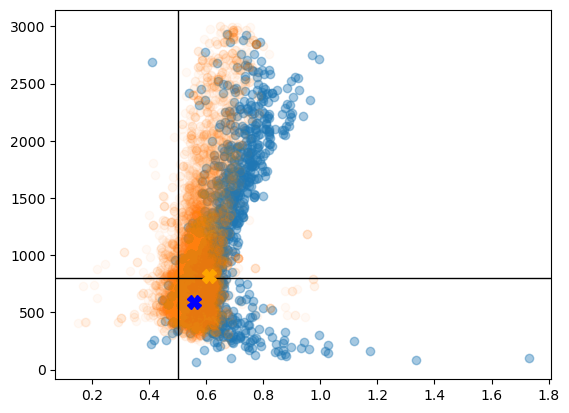

In [135]:
plt.plot(samples_sbi.T[0,:],samples_sbi.T[1,:], marker='o', ls='', alpha=0.4)
plt.plot(mcmc_res[1].flatchain.T[0,:], mcmc_res[1].flatchain.T[1,:], marker='o', ls='', alpha=0.04)
plt.plot([0.5],[800], marker='+', ms=1000, color='k')
plt.plot([best_fit[0][0]],[best_fit[0][1]], marker='X', ms=10, color='orange')
plt.plot([bf_mcmc[0][0]],[bf_mcmc[0][1]], marker='X', ms=10, color='blue')

In [133]:
bf_mcmc[0][1]

np.float64(587.4294345418549)